In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import cv2
import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#count the number of images in the respective classes 0 - Brain Tumor  and 1 -Healthy
ROOT_DIR ="/content/drive/MyDrive/Brain Tumor Data Set"
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
   number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

number_of_images.items()

dict_items([('Healthy', 2087), ('Brain Tumor', 2513)])

In [ ]:
os.listdir("/content/drive/MyDrive/Brain Tumor Data Set")

['Healthy', 'Brain Tumor']

**We will split the data such that** 

*   70 % for Train Data
*   15% for validation
*  15% for Testing









In [ ]:
def dataFolder(p, split):
#we will create a folder

  if not os.path.exists("./"+p):
    os.mkdir("./"+p)

    for dir in os.listdir(ROOT_DIR):
      os.makedirs("./"+p+"/"+dir)

      for img in np.random.choice(a = os.listdir(os.path.join(ROOT_DIR, dir)),
                                size = (math.floor(split*number_of_images[dir])-5), 
                                 replace = False ):
       O = os.path.join(ROOT_DIR, dir, img)
       D = os.path.join("./"+p, dir)
       shutil.copy(O, D) #copy content from source to destination
       #os.remove(O)
  else:
     print( f"{p}Folder Exist")

In [ ]:
dataFolder("train", 0.7)

In [ ]:
dataFolder("val", 0.15)

In [ ]:
dataFolder("test", 0.15)

**Model Build**

In [ ]:
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import keras

In [ ]:
#CNN Model

model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = (224, 224, 3) ))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu' ))
model.add(MaxPool2D(pool_size=(2,2) ))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu' ))
model.add(MaxPool2D(pool_size=(2,2) ))

model.add(Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu' ))
model.add(MaxPool2D(pool_size=(2,2) ))

model.add(Dropout(rate = 0.25))

model.add(Flatten())
model.add(Dense(units=64, activation = 'relu'))
model.add(Dropout(rate =0.25))
model.add(Dense(units=1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)       7

Preparing our data using Data Generator

In [ ]:
#rescale used for normalize data
def preprocessingImages1(path):
  """
  input : path
  output : Pre processed images
  """
  image_data = ImageDataGenerator(zoom_range=0.2, shear_range= 0.2, rescale =1/255, horizontal_flip=True)
  image = image_data.flow_from_directory(directory = path, target_size = (224, 224), batch_size =32, class_mode ='binary')
  return image

In [ ]:
path ="/content/train"
train_data = preprocessingImages1(path)

Found 3209 images belonging to 2 classes.


In [ ]:
train_data.class_indices

{'Brain Tumor': 0, 'Healthy': 1}

In [ ]:
def preprocessingImages2(path):
  """
  input : path
  output : Pre processed images
  """
  image_data = ImageDataGenerator(rescale =1/255)
  image = image_data.flow_from_directory(directory = path, target_size = (224, 224), batch_size =32, class_mode ='binary')
  return image

In [ ]:
path = "/content/test"
test_data = preprocessingImages2(path)

Found 679 images belonging to 2 classes.


In [ ]:
path = "/content/val"
val_data = preprocessingImages2(path)

Found 679 images belonging to 2 classes.


In [ ]:
#Early stopping and model check point

from keras. callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#early stopping
es = EarlyStopping(monitor="val_accuracy", min_delta=0.01, patience =3, verbose =1, mode = 'auto')

#model check point
mc = ModelCheckpoint(monitor="val_accuracy", filepath="./bestmodel.h5", verbose =1, save_best_only=True, mode = 'auto')

#annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=0.001)

cd = [es, mc]

In [ ]:
# we have used binay classification because of image is either cancerous or not
model.compile(optimizer ='Adam', loss = keras.losses.binary_crossentropy, metrics=['accuracy'])

**Model Training**

In [ ]:
hs = model.fit(train_data, 
               batch_size=32, 
               epochs=30, 
               verbose =1,
               callbacks= cd, 
               validation_data = val_data,
               validation_steps=16)

Epoch 1/30
101/101 [==============================] - ETA: 0s - loss: 0.6281 - accuracy: 0.6494
Epoch 1: val_accuracy improved from -inf to 0.78516, saving model to ./bestmodel.h5
101/101 [==============================] - 64s 511ms/step - loss: 0.6281 - accuracy: 0.6494 - val_loss: 0.4676 - val_accuracy: 0.7852
Epoch 2/30
101/101 [==============================] - ETA: 0s - loss: 0.4822 - accuracy: 0.7853
Epoch 2: val_accuracy did not improve from 0.78516
101/101 [==============================] - 51s 504ms/step - loss: 0.4822 - accuracy: 0.7853 - val_loss: 0.5134 - val_accuracy: 0.7559
Epoch 3/30
101/101 [==============================] - ETA: 0s - loss: 0.4296 - accuracy: 0.8161
Epoch 3: val_accuracy improved from 0.78516 to 0.85547, saving model to ./bestmodel.h5
101/101 [==============================] - 51s 507ms/step - loss: 0.4296 - accuracy: 0.8161 - val_loss: 0.3740 - val_accuracy: 0.8555
Epoch 4/30
101/101 [==============================] - ETA: 0s - loss: 0.4006 - accuracy:

In [ ]:
#Model Graphical Interpretation

h = hs.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

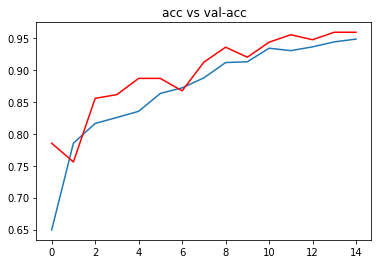

In [ ]:
import matplotlib.pyplot as plt

plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c = "red")

plt.title("acc vs val-acc")
plt.show()

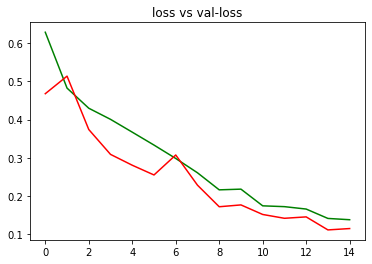

In [ ]:
import matplotlib.pyplot as plt

plt.plot(h['loss'], c ="green")
plt.plot(h['val_loss'], c = "red")

plt.title("loss vs val-loss")
plt.show()

In [ ]:
#Model Accuracy
from keras.models import load_model

model = load_model("/content/bestmodel.h5")

**Model accuracy**

In [ ]:
acc = model.evaluate(test_data)[1]

print(f"The accuracy of our model is {acc*100} %")

22/22 [==============================] - 3s 128ms/step - loss: 0.1089 - accuracy: 0.9632
The accuracy of our model is 96.31811380386353 %


In [ ]:
from keras.preprocessing.image import load_img, img_to_array

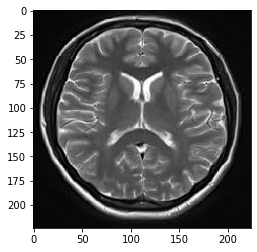

The MRI is Not having a Tumor


In [ ]:
path = "/content/drive/MyDrive/Brain Tumor Data Set/Healthy/Not Cancer  (974).jpg"

img = load_img(path, target_size =(224, 224))
input_arr = img_to_array(img)/255

plt.imshow(input_arr)
plt.show()

input_arr.shape

input_arr = np.expand_dims(input_arr, axis=0)

pred = (model.predict(input_arr)>0.5).astype("int32")
pred

if pred == 0:
  print("The MRI is having a Tumor")
else:
  print("The MRI is Not having a Tumor")


In [ ]:
train_data.class_indices

{'Brain Tumor': 0, 'Healthy': 1}

Preparing our data using Data Generator

In [ ]:
#in place of rescale we used preprocessing_input
def preprocessingImages3(path):
  """
  input : path
  output : Pre processed images
  """
  image_data = ImageDataGenerator(zoom_range=0.2, shear_range= 0.2, preprocessing_function = preprocess_input, horizontal_flip=True)
  image = image_data.flow_from_directory(directory = path, target_size = (224, 224), batch_size =32, class_mode ='binary')
  return image

In [ ]:
path ="/content/train"
train_data1 = preprocessingImages3(path)

Found 3209 images belonging to 2 classes.


In [ ]:
def preprocessingImages4(path):
  """
  input : path
  output : Pre processed images
  """
  image_data = ImageDataGenerator(preprocessing_function = preprocess_input)
  image = image_data.flow_from_directory(directory = path, target_size = (224, 224), batch_size =32, class_mode ='binary')
  return image

In [ ]:
path = "/content/test"
test_data1 = preprocessingImages4(path)

Found 679 images belonging to 2 classes.


In [ ]:
path = "/content/val"
val_data1 = preprocessingImages4(path)

Found 679 images belonging to 2 classes.


**Model Training**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Flatten, Dense
from keras.models import Model, load_model
from keras.applications.mobilenet import MobileNet, preprocess_input
import keras

In [ ]:
base_model = MobileNet(input_shape = (224,224,3), include_top = False)

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [ ]:
X = Flatten()(base_model.output)
X = Dense(units=1, activation ='sigmoid')(X)

model = Model(base_model.input, X)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [ ]:
# we have used binay classification because of image is either cancerous or not
model.compile(optimizer ='rmsprop', loss = keras.losses.binary_crossentropy, metrics=['accuracy'])

In [ ]:
#Early stopping and model check point

from keras. callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#early stopping
es = EarlyStopping(monitor="val_accuracy", min_delta=0.01, patience =3, verbose =1, mode = 'auto')

#model check point
mc = ModelCheckpoint(monitor="val_accuracy", filepath="./bestmodel.h5", verbose =1, save_best_only=True, mode = 'auto')

#annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=0.001)

cd = [es, mc]

In [ ]:
hist = model.fit(train_data1, 
               batch_size=64, 
               epochs=30, 
               verbose =1,
               callbacks= cd, 
               validation_data = val_data1,
               validation_steps=16)

Epoch 1/30
101/101 [==============================] - ETA: 0s - loss: 1.6590 - accuracy: 0.8380
Epoch 1: val_accuracy improved from -inf to 0.88672, saving model to ./bestmodel.h5
101/101 [==============================] - 62s 575ms/step - loss: 1.6590 - accuracy: 0.8380 - val_loss: 0.9668 - val_accuracy: 0.8867
Epoch 2/30
101/101 [==============================] - ETA: 0s - loss: 0.8608 - accuracy: 0.9115
Epoch 2: val_accuracy improved from 0.88672 to 0.90430, saving model to ./bestmodel.h5
101/101 [==============================] - 67s 653ms/step - loss: 0.8608 - accuracy: 0.9115 - val_loss: 0.8195 - val_accuracy: 0.9043
Epoch 3/30
101/101 [==============================] - ETA: 0s - loss: 0.4756 - accuracy: 0.9436
Epoch 3: val_accuracy improved from 0.90430 to 0.98242, saving model to ./bestmodel.h5
101/101 [==============================] - 51s 506ms/step - loss: 0.4756 - accuracy: 0.9436 - val_loss: 0.1110 - val_accuracy: 0.9824
Epoch 4/30
101/101 [==============================] 

In [ ]:
#load the best fit model

model = load_model("/content/bestmodel.h5")

In [ ]:
acc = model.evaluate(test_data1)[1]

print(f"The accuracy of our model is {acc*100} %")

22/22 [==============================] - 4s 149ms/step - loss: 0.2754 - accuracy: 0.9735
The accuracy of our model is 97.34904170036316 %


In [ ]:
h = hist.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

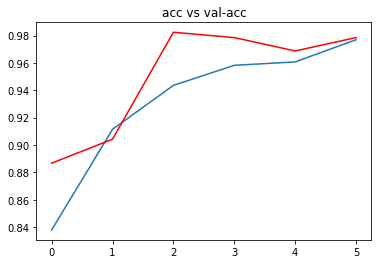

In [ ]:
import matplotlib.pyplot as plt

plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c = "red")

plt.title("acc vs val-acc")
plt.show()

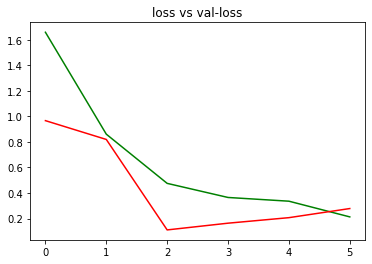

In [ ]:
import matplotlib.pyplot as plt

plt.plot(h['loss'], c ="green")
plt.plot(h['val_loss'], c = "red")

plt.title("loss vs val-loss")
plt.show()

In [ ]:
from keras.preprocessing import image

The MRI is having a Brain Tumor


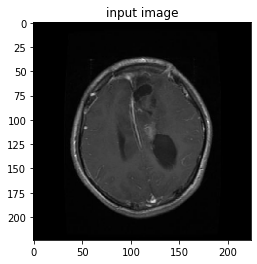

In [ ]:
#path for the image to see if it predicts correct class

path = "/content/drive/MyDrive/Brain Tumor Data Set/Brain Tumor/Cancer (564).jpg"

img = image.load_img(path, target_size =(224, 224))

i = image.img_to_array(img)/255
#i = preprocess_input(i)/255
input_arr = np.array([i])
input_arr.shape

pred = (model.predict(input_arr)>0.5).astype("int32")


if pred == 0:
  print("The MRI is having a Brain Tumor")
else:
  print("The MRI is Not having a Brain Tumor--->Healthy image")

#to display the image
plt.imshow(input_arr[0])
plt.title("input image")
plt.show()